In [1]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier, ShapeDTW #Shapetest
#from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt


In [3]:
dataset = "Adiac"
f = np.loadtxt(f"Smoothed/{dataset}_smoothed.csv", delimiter=",")
np.random.seed(0)
np.random.shuffle(f)
ts = f[:, 1:]
labels = f[:, 0].astype(int)

In [ ]:
ts = np.zeros((999, f.shape[1] - 1))
ts[0:333] = f[f[:, 0] == 1][0:333, 1:]
ts[333:666] = f[f[:, 0] == 2][0:333, 1:]
ts[666:999] = f[f[:, 0] == 3][0:333, 1:]
ts

In [4]:
def walker(ts, m):
    X = np.zeros_like(ts)
    col = ts.shape[0]
    N = ts.shape[1]
    
    for i in range(0,col):
        w = X[i, :]
        y = ts[i, :]
        
        w[0] = y[0]
        w[1] = y[1]
        for k in range(2, N):
            w_inert = w[k-1] * 2 - w[k-2]
            w[k] = w_inert + (y[k] - w_inert)/m
        
        X[i, :] = w
    
    return X

In [5]:
def testaccuracy(m, train = False):
    X = walker(ts, m)
        
    #np.random.seed(0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, labels)
    classifier = KNeighborsTimeSeriesClassifier(distance="euclidean")
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    correct = 0
    total = X_train.shape[0]
    if train:
        
        
        i = 0
        while i < len(X_train):
            classifier = KNeighborsTimeSeriesClassifier(distance="euclidean")
            ind = np.ones(X_train.shape[0], int)
            ind[i] = 0
            test = X_train[i]
            
            ind = ind.astype(bool)
            
            classifier.fit(X_train[ind], y_train[ind])
            
            pred = classifier.predict(np.array([test]))
            
            if pred[0] == y_train[i]:
                correct += 1
            
            i += 1
    
    return accuracy_score(y_test, y_pred), correct/total

In [ ]:
def trainaccuracy(m):
    X = walker(ts, m)
    
    np.random.seed(0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, labels)
    
    correct = 0
    total = X_train.shape[0]
    i = 0
    while i < len(X_train):
        classifier = KNeighborsTimeSeriesClassifier(distance="euclidean")
        ind = np.ones(X_train.shape[0], int)
        ind[i] = 0
        test = X_train[i]
        
        ind = ind.astype(bool)
        
        classifier.fit(X_train[ind], y_train[ind])
        
        pred = classifier.predict(np.array([test]))
        
        if pred[0] == y_train[i]:
            correct += 1
        
        i += 1
    
    return correct/total

In [17]:
masses = np.arange(1, 20.1, 0.1)
accuracy = np.zeros((masses.shape[0], 2))

In [18]:

i = 0
for m in masses:
    result = []
    for _ in range(0, 5):
        result.append(testaccuracy(m))
    
    result = np.array(result)
    result = np.mean(result, axis = 0)
    accuracy[i, 0] = result[0]
    accuracy[i, 1] = result[1]
    i += 1
    

Text(0.5, 1.0, 'Adiac')

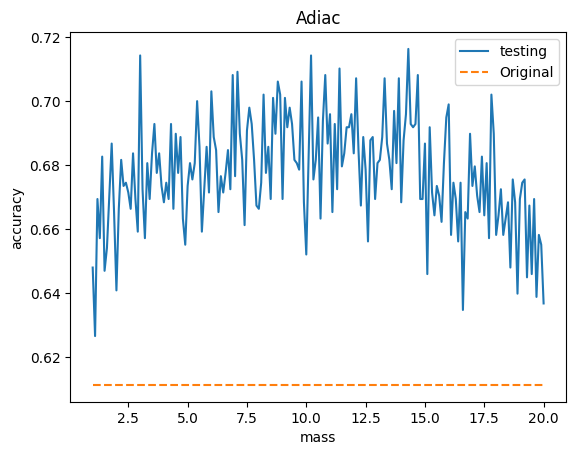

In [21]:
dash = [0.61125319] * masses.shape[0]
dash = np.array(dash)

plt.clf()
plt.plot(masses, accuracy[:, 0], "-", label="testing")
#plt.plot(masses, accuracy[:, 1], ".-", label="training")
plt.plot(masses, dash, "--", label="Original" )
plt.xlabel("mass")
plt.ylabel("accuracy")
plt.legend()
plt.title(dataset)

In [22]:
accuracy

array([[0.64795918, 0.        ],
       [0.62653061, 0.        ],
       [0.66938776, 0.        ],
       [0.65714286, 0.        ],
       [0.68265306, 0.        ],
       [0.64693878, 0.        ],
       [0.65408163, 0.        ],
       [0.67040816, 0.        ],
       [0.68673469, 0.        ],
       [0.66530612, 0.        ],
       [0.64081633, 0.        ],
       [0.66632653, 0.        ],
       [0.68163265, 0.        ],
       [0.67346939, 0.        ],
       [0.6744898 , 0.        ],
       [0.67142857, 0.        ],
       [0.66632653, 0.        ],
       [0.68367347, 0.        ],
       [0.66938776, 0.        ],
       [0.65918367, 0.        ],
       [0.71428571, 0.        ],
       [0.67244898, 0.        ],
       [0.65714286, 0.        ],
       [0.68061224, 0.        ],
       [0.66938776, 0.        ],
       [0.68367347, 0.        ],
       [0.69285714, 0.        ],
       [0.67755102, 0.        ],
       [0.68367347, 0.        ],
       [0.67346939, 0.        ],
       [0.

In [8]:
testaccuracy(1)

(0.6632653061224489, 0.0)